In [543]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sl_ai.utils import clean_listdir

RANDOM_SEED = 42

In [544]:
# dataset = Path('gestures_dataset_new.csv')
DATASET_CSV = Path('../gestures_dataset.csv')
DATASET_ROOT = Path('../ai_data/vgt-all')

UPLOADED_DATASET_CSV = Path('../uploaded_gestures_dataset.csv')
UPLOADED_GESTURES_ROOT = Path('../ai_data/vgt-uploaded')

In [545]:
def handedness_data_from_directory_names(dataset_location: Path):
    handedness_data = {}
    for gesture_folder in clean_listdir(dataset_location):
        gesture_name, handedness_string = gesture_folder.split('_')
        handedness_data[gesture_name] = (handedness_string[0] == '1', handedness_string[1] == '1')
    return handedness_data

In [546]:
%load_ext autoreload
%autoreload 2
from sl_ai.dataset import GestureDataset

gesture_dataset: GestureDataset = GestureDataset()
# gesture_dataset.scan_videos(dataset_location=DATASET_ROOT, handedness_data=handedness_data_from_directory_names(DATASET_ROOT))
# gesture_dataset.analyze_videos(csv_out_path=DATASET_CSV, overwrite=True)
gesture_dataset.load_from_csv(DATASET_CSV)


for user_folder in clean_listdir(UPLOADED_GESTURES_ROOT):
    for gesture_folder in clean_listdir(UPLOADED_GESTURES_ROOT / user_folder):
        csv_files = list(
            filter(
                lambda file: file.endswith(".csv"),
                clean_listdir(
                    UPLOADED_GESTURES_ROOT / user_folder / gesture_folder
                ),
            )
        )
        if not csv_files:
            print(
                "Warning: Found a uploaded gesture folder without a dataset.csv file."
            )
            continue
        dataset_file = csv_files[0]
        print(
            f"Loading dataset from {UPLOADED_GESTURES_ROOT / user_folder / gesture_folder / dataset_file}"
        )
        *gestures_words, handedness_string = gesture_folder.split("_")
        gesture_name = "_".join(gestures_words)
        uploaded_gesture_dataset = GestureDataset(single_gesture=True)
        uploaded_gesture_dataset.scan_videos(
            dataset_location=UPLOADED_GESTURES_ROOT
            / user_folder
            / gesture_folder,
            handedness_data={
                gesture_name: (
                    handedness_string[0] == "1",
                    handedness_string[1] == "1",
                )
            },
        )
        uploaded_gesture_dataset.load_from_csv(
            csv_path=UPLOADED_GESTURES_ROOT
            / user_folder
            / gesture_folder
            / dataset_file
        )
        gesture_dataset.append_dataset(uploaded_gesture_dataset)

gesture_dataset.summary()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
belgië(0 -> 0)
bowlen(1 -> 1)
computer(2 -> 2)
duidelijk(3 -> 3)
fietsen(4 -> 4)
gebaar(5 -> 5)
geit(6 -> 6)
hallo(7 -> 7)
kameel(8 -> 8)
muis(9 -> 9)
tennis(10 -> 10)
verenigde staten(11 -> 11)
Something went wrong while processing usa - 2023-01-04_16-18-24.mp4: list index out of range
Dataset contain 12 gestures.


In [547]:
%load_ext autoreload
%autoreload 2
from sl_ai.gesture_classifier import GestureClassifier
classifier: GestureClassifier = GestureClassifier(gesture_dataset=gesture_dataset)
classifier.train(train_size=.5)
# classifier.summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Dataset contain 12 gestures.
Epoch 1/1000
87/87 [==============================] - 1s 3ms/step - loss: 2.3969 - sparse_categorical_accuracy: 0.1149 - val_loss: 2.1391 - val_sparse_categorical_accuracy: 0.2727
Epoch 2/1000
87/87 [==============================] - 0s 1ms/step - loss: 2.1167 - sparse_categorical_accuracy: 0.2184 - val_loss: 1.9145 - val_sparse_categorical_accuracy: 0.2955
Epoch 3/1000
87/87 [==============================] - 0s 1ms/step - loss: 1.8954 - sparse_categorical_accuracy: 0.2874 - val_loss: 1.6933 - val_sparse_categorical_accuracy: 0.3636
Epoch 4/1000
87/87 [==============================] - 0s 1ms/step - loss: 1.7363 - sparse_categorical_accuracy: 0.2529 - val_loss: 1.5913 - val_sparse_categorical_accuracy: 0.3864
Epoch 5/1000
87/87 [==============================] - 0s 1ms/step - loss: 1.6389 - sparse_categorical_accuracy: 0.3103 - val_loss: 1.5163 - val_sparse_categorical_

In [548]:
classifier.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_65 (Dropout)        (None, 400)               0         
                                                                 
 dense_124 (Dense)           (None, 24)                9624      
                                                                 
 dropout_66 (Dropout)        (None, 24)                0         
                                                                 
 dense_125 (Dense)           (None, 12)                300       
                                                                 
 dense_126 (Dense)           (None, 12)                156       
                                                                 
Total params: 10,080
Trainable params: 10,080
Non-trainable params: 0
_________________________________________________________________


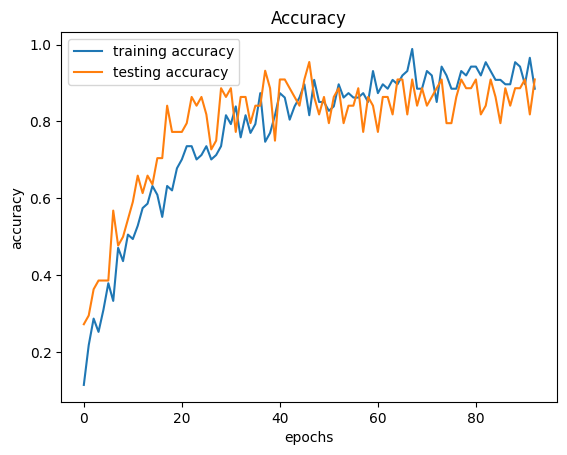

In [549]:
classifier.visualize_accuracy()

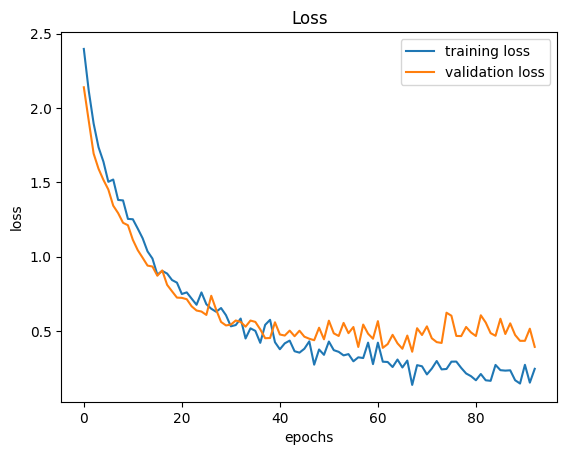

In [550]:
classifier.visualize_loss()

2/2 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      1.00      1.00         3
           2       0.50      1.00      0.67         4
           3       1.00      0.50      0.67         4
           4       0.00      0.00      0.00         3
           5       0.33      0.50      0.40         2
           6       0.00      0.00      0.00         4
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       0.83      1.00      0.91         5
          11       1.00      0.67      0.80         3

    accuracy                           0.73        44
   macro avg       0.68      0.69      0.66        44
weighted avg       0.68      0.73      0.68        44



C:\Users\Arthur\Desktop\EhB\22-23\Final Work\Sign-Language-Learning-Tool\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Arthur\Desktop\EhB\22-23\Final Work\Sign-Language-Learning-Tool\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Arthur\Desktop\EhB\22-23\Final Work\Sign-Language-Learning-Tool\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

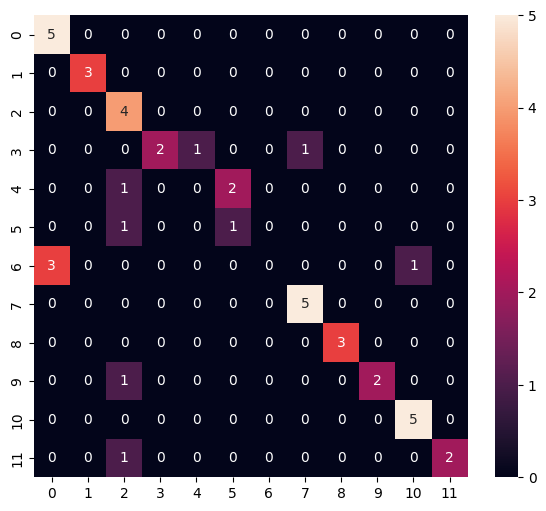

In [551]:
classifier.confusion_matrix()

In [569]:
classifier.save_model("../model.h5")

------------

# Test predictions

In [553]:
# from sl_ai.dataset import detect_hands_task, GestureData
#
# video_path = Path('../ai_data/vgt-all/duidelijk_11/duidelijk - 2023-01-04_16-41-21.mp4')
# gesture_data = GestureData(name="hello", left_hand=False, right_hand=True)
# video_name, (frame_width, frame_height), left_landmarks, right_landmarks = detect_hands_task(gesture_data, video_path)


In [554]:
# from sl_ai.dataset import preprocess_landmarks
# from copy import deepcopy
# left_landmarks_copy = deepcopy(left_landmarks)
# right_landmarks_copy = deepcopy(right_landmarks)
# preprocess_landmarks(left_landmarks_copy, right_landmarks_copy, None, None)

In [555]:
# from sl_ai.dataset import pre_process_point_history_center
#
# for i, landmarks in left_landmarks_copy.items():
#     left_landmarks_copy[i] = pre_process_point_history_center(None, None, landmarks)
# for i, landmarks in right_landmarks_copy.items():
#     right_landmarks_copy[i] = pre_process_point_history_center(None, None, landmarks)

In [556]:
# result = classifier.predict(left_landmarks_copy, right_landmarks_copy)
# classes_x = np.argmax(result, axis=1)
# print(classes_x)
# prediction_percents = (result*100)
# frame = pd.DataFrame(prediction_percents.astype(np.int32))
# print(frame)

In [557]:
# result

In [558]:
# l = np.array(left_landmarks_copy[12], dtype='float32')
# r = np.array(right_landmarks_copy[12], dtype='float32')
#
# x_data = np.concatenate((l, r), axis=0)
# x_data = x_data.reshape((-1, x_data.shape[0]))
# results = classifier.model.predict(x_data, batch_size=1)
# classes_x = np.argmax(result, axis=1)
# print(classes_x)
# prediction_percents = (result*100)
# frame = pd.DataFrame(prediction_percents.astype(np.int32))
# print(frame)

In [559]:
# classifier.train(train_size=.5)
# classifier.summary()

In [560]:
# classifier.visualize_accuracy()

In [561]:
# classifier.visualize_loss()

In [562]:
# classifier.confusion_matrix()

# Test predictions

In [563]:
# from sl_ai.dataset import detect_hands_task, GestureData
#
# video_path = Path('../ai_data/vgt-all/duidelijk_11/duidelijk - 2023-01-04_16-41-21.mp4')
# gesture_data = GestureData(name="hello", left_hand=False, right_hand=True)
# video_name, (frame_width, frame_height), left_landmarks, right_landmarks = detect_hands_task(gesture_data, video_path)


In [564]:
# from sl_ai.dataset import preprocess_landmarks
# from copy import deepcopy
# left_landmarks_copy = deepcopy(left_landmarks)
# right_landmarks_copy = deepcopy(right_landmarks)
# preprocess_landmarks(left_landmarks_copy, right_landmarks_copy, None, None)

In [565]:
# from sl_ai.dataset import pre_process_point_history_center
#
# for i, landmarks in left_landmarks_copy.items():
#     left_landmarks_copy[i] = pre_process_point_history_center(None, None, landmarks)
# for i, landmarks in right_landmarks_copy.items():
#     right_landmarks_copy[i] = pre_process_point_history_center(None, None, landmarks)

In [566]:
# result = classifier.predict(left_landmarks_copy, right_landmarks_copy)
# classes_x = np.argmax(result, axis=1)
# print(classes_x)
# prediction_percents = (result*100)
# frame = pd.DataFrame(prediction_percents.astype(np.int32))
# print(frame)

In [567]:
# result

In [568]:
# l = np.array(left_landmarks_copy[12], dtype='float32')
# r = np.array(right_landmarks_copy[12], dtype='float32')
#
# x_data = np.concatenate((l, r), axis=0)
# x_data = x_data.reshape((-1, x_data.shape[0]))
# results = classifier.model.predict(x_data, batch_size=1)
# classes_x = np.argmax(result, axis=1)
# print(classes_x)
# prediction_percents = (result*100)
# frame = pd.DataFrame(prediction_percents.astype(np.int32))
# print(frame)